In [12]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# библиотека для преобразованя категориальных признаков
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from catboost import CatBoostClassifier, Pool

In [13]:
df = pd.read_csv('dataset.csv', sep=',')

In [14]:
df['date_reg'] = pd.to_datetime(df['date_reg'], format="%Y-%m-%d")

In [15]:
df['date_reg_cat_feat'] = df['date_reg']

In [16]:
cat_feat = ['market', 'group', 'archetype', 'hardware', 'channel', 'dealer', 'phone', 'type_t', 'device', 'date_reg_cat_feat']

In [17]:
df.head()

,client_id,date_reg,market,group,archetype,hardware,channel,dealer,phone,type_t,...,all_calls_dur,quantity_recharge,recharges_sum,last_day_recharge,mean_recharges_sum,mean_balance,start_balance,final_balance,difference_balance,date_reg_cat_feat
0,09777552-cc75-4f03-9438-11c3a7480f97,2016-05-10,R25,PP1_9,PP2_0,PPT1,C1_22,C2_22,D2254,DT1_6,...,6506.0,1.0,1001.11200,1.0,1001.112000,1202.535734,2269.187200,1.334816,-2267.852384,2016-05-10
1,5fbe2ea9-0c80-4164-b703-416b85c23d8c,2016-04-19,R25,PP1_9,PP2_0,PPT1,C1_6,C2_0,NAN,NAN,...,27599.0,2.0,5526.13824,13.0,2763.069120,1006.985190,2378.642112,447.830768,-1930.811344,2016-04-19
2,8cbd48c0-8f90-4f08-bef7-8f09d9924e55,2016-05-19,R25,PP1_9,PP2_0,PPT1,C1_6,C2_0,D2594,DT1_6,...,141308.0,9.0,7014.45808,30.0,779.384231,291.946506,1134.593600,1355.505648,220.912048,2016-05-19
3,ffda8d15-cd38-45c3-84ba-29a9811ed79e,2016-05-28,R25,PP1_9,PP2_0,PPT1,C1_22,C2_11,D3131,DT1_6,...,2931.0,0.0,0.00000,0.0,0.000000,406.673941,1268.075200,-40.044480,-1308.119680,2016-05-28
4,1f9618ad-a980-4110-af32-9741e491a728,2016-05-23,R4,PP1_9,PP2_0,PPT1,C1_28,C2_21,D454,DT1_6,...,213.0,1.0,6674.08000,1.0,6674.080000,0.000000,0.000000,0.000000,0.000000,2016-05-23


# Кодирование категориальных признаков

## LabelEncoder

In [18]:
df_le = df.copy()

#cat_feat_le = ['market', 'group', 'archetype', 'hardware', 'channel', 'dealer', 'type_t', 'device']


le = LabelEncoder()
for i in cat_feat:
    le.fit(df_le[i].tolist())
    cat_trsfm = le.transform(df_le[i].tolist())
    se = pd.Series(cat_trsfm)
    df_le[i+'_le'] = se.values
    del df_le[i]

#del df_le['phone']

### train - test LabelEncoder
Обучающая и тесторая выборка с закодированными кат. признаками с помощью LabelEncoder 

In [19]:
X_train_le = df_le[df_le['date_reg'] < '2016-05-13']
X_test_le = df_le[df_le['date_reg'] >= '2016-05-13']

y_train_le = X_train_le[['client_id', 'churn']]
y_test_le = X_test_le[['client_id', 'churn']]

del X_train_le['churn']
del X_test_le['churn']
del X_train_le['date_reg']
del X_test_le['date_reg']


X_train_le = X_train_le.set_index('client_id')
y_train_le = y_train_le.set_index('client_id')
X_test_le = X_test_le.set_index('client_id')
y_test_le = y_test_le.set_index('client_id')

## OneHotEncoder (Dummy)
Обучающая и тесторая выборка с закодированными кат. признаками с помощью OneHotEncoder 

In [20]:
df_dummy = df.copy()

# исключаю признак 'phone' для dummy-кодирования из-за большого количества уникальных значений 
cat_feat.remove('phone')

ohe = OneHotEncoder(sparse=False) 
for j in cat_feat:
    new_ohe_features = ohe.fit_transform(df_dummy[j].values.reshape(-1, 1))
    tmp = pd.DataFrame(new_ohe_features, columns=[j + '=' + str(i) for i in range(new_ohe_features.shape[1])], dtype='int64')
    df_dummy = pd.concat([df_dummy, tmp], axis=1)
    del df_dummy[j]

del df_dummy['phone']

# возвращаю 'phone' на место
cat_feat.append('phone')

### train - test Dummy 

In [21]:
X_train_dummy = df_dummy[df_dummy['date_reg'] < '2016-05-13']
X_test_dummy = df_dummy[df_dummy['date_reg'] >= '2016-05-13']

y_train_dummy = X_train_dummy[['client_id', 'churn']]
y_test_dummy = X_test_dummy[['client_id', 'churn']]

del X_train_dummy['churn']
del X_test_dummy['churn']
del X_train_dummy['date_reg']
del X_test_dummy['date_reg']


X_train_dummy = X_train_dummy.set_index('client_id')
y_train_dummy = y_train_dummy.set_index('client_id')
X_test_dummy = X_test_dummy.set_index('client_id')
y_test_dummy = y_test_dummy.set_index('client_id')

## train - test (без преобразования категориальных признаков) 

In [54]:
df_catf = df.copy()
del df_catf['date_reg_cat_feat']

X_train_catf = df_catf[df_catf['date_reg'] < '2016-05-13']
X_test_catf = df_catf[df_catf['date_reg'] >= '2016-05-13']

y_train_catf = X_train_catf[['client_id', 'churn']]
y_test_catf = X_test_catf[['client_id', 'churn']]

del X_train_catf['churn']
del X_test_catf['churn']
del X_train_catf['date_reg']
del X_test_catf['date_reg']

X_train_catf = X_train_catf.set_index('client_id')
y_train_catf = y_train_catf.set_index('client_id')
X_test_catf = X_test_catf.set_index('client_id')
y_test_catf = y_test_catf.set_index('client_id')

# CatBoost

## 1. CatBoost Dummy

In [23]:
%%time
ctb_dummy = CatBoostClassifier()
ctb_dummy.fit(X_train_dummy, y_train_dummy)

Learning rate set to 0.090096
0:	learn: 0.6521770	total: 1.83s	remaining: 30m 28s
1:	learn: 0.6181375	total: 1.9s	remaining: 15m 46s
2:	learn: 0.5908384	total: 1.98s	remaining: 10m 56s
3:	learn: 0.5680008	total: 2.07s	remaining: 8m 35s
4:	learn: 0.5506662	total: 2.16s	remaining: 7m 10s
5:	learn: 0.5372625	total: 2.24s	remaining: 6m 10s
6:	learn: 0.5247758	total: 2.33s	remaining: 5m 31s
7:	learn: 0.5141169	total: 2.41s	remaining: 4m 58s
8:	learn: 0.5055904	total: 2.47s	remaining: 4m 31s
9:	learn: 0.4988240	total: 2.53s	remaining: 4m 10s
10:	learn: 0.4929597	total: 2.61s	remaining: 3m 54s
11:	learn: 0.4882066	total: 2.68s	remaining: 3m 40s
12:	learn: 0.4839836	total: 2.76s	remaining: 3m 29s
13:	learn: 0.4807037	total: 2.87s	remaining: 3m 22s
14:	learn: 0.4778965	total: 2.94s	remaining: 3m 13s
15:	learn: 0.4756071	total: 3.02s	remaining: 3m 5s
16:	learn: 0.4735345	total: 3.09s	remaining: 2m 58s
17:	learn: 0.4718017	total: 3.15s	remaining: 2m 51s
18:	learn: 0.4701941	total: 3.21s	remaining

158:	learn: 0.4404276	total: 14.1s	remaining: 1m 14s
159:	learn: 0.4403460	total: 14.2s	remaining: 1m 14s
160:	learn: 0.4402527	total: 14.2s	remaining: 1m 14s
161:	learn: 0.4401734	total: 14.3s	remaining: 1m 14s
162:	learn: 0.4400991	total: 14.4s	remaining: 1m 13s
163:	learn: 0.4400089	total: 14.5s	remaining: 1m 13s
164:	learn: 0.4399157	total: 14.5s	remaining: 1m 13s
165:	learn: 0.4398438	total: 14.6s	remaining: 1m 13s
166:	learn: 0.4397550	total: 14.7s	remaining: 1m 13s
167:	learn: 0.4396625	total: 14.7s	remaining: 1m 12s
168:	learn: 0.4395652	total: 14.8s	remaining: 1m 12s
169:	learn: 0.4394948	total: 14.9s	remaining: 1m 12s
170:	learn: 0.4394204	total: 14.9s	remaining: 1m 12s
171:	learn: 0.4393565	total: 15s	remaining: 1m 12s
172:	learn: 0.4393037	total: 15.1s	remaining: 1m 12s
173:	learn: 0.4392004	total: 15.1s	remaining: 1m 11s
174:	learn: 0.4391020	total: 15.2s	remaining: 1m 11s
175:	learn: 0.4390102	total: 15.3s	remaining: 1m 11s
176:	learn: 0.4389230	total: 15.3s	remaining: 1m

318:	learn: 0.4294593	total: 25.1s	remaining: 53.5s
319:	learn: 0.4293809	total: 25.1s	remaining: 53.4s
320:	learn: 0.4293328	total: 25.2s	remaining: 53.3s
321:	learn: 0.4292919	total: 25.3s	remaining: 53.2s
322:	learn: 0.4292429	total: 25.3s	remaining: 53.1s
323:	learn: 0.4291816	total: 25.4s	remaining: 53s
324:	learn: 0.4291121	total: 25.5s	remaining: 52.9s
325:	learn: 0.4290489	total: 25.5s	remaining: 52.8s
326:	learn: 0.4289974	total: 25.6s	remaining: 52.7s
327:	learn: 0.4289370	total: 25.7s	remaining: 52.6s
328:	learn: 0.4288870	total: 25.7s	remaining: 52.5s
329:	learn: 0.4288077	total: 25.8s	remaining: 52.4s
330:	learn: 0.4287693	total: 25.9s	remaining: 52.3s
331:	learn: 0.4287310	total: 26s	remaining: 52.2s
332:	learn: 0.4286920	total: 26s	remaining: 52.1s
333:	learn: 0.4286225	total: 26.1s	remaining: 52s
334:	learn: 0.4285529	total: 26.2s	remaining: 52s
335:	learn: 0.4284928	total: 26.2s	remaining: 51.9s
336:	learn: 0.4284442	total: 26.3s	remaining: 51.8s
337:	learn: 0.4283979	

477:	learn: 0.4213444	total: 36.1s	remaining: 39.4s
478:	learn: 0.4213037	total: 36.1s	remaining: 39.3s
479:	learn: 0.4212504	total: 36.2s	remaining: 39.2s
480:	learn: 0.4212015	total: 36.3s	remaining: 39.1s
481:	learn: 0.4211617	total: 36.3s	remaining: 39s
482:	learn: 0.4211139	total: 36.4s	remaining: 38.9s
483:	learn: 0.4210765	total: 36.5s	remaining: 38.9s
484:	learn: 0.4210283	total: 36.5s	remaining: 38.8s
485:	learn: 0.4209850	total: 36.6s	remaining: 38.7s
486:	learn: 0.4209422	total: 36.7s	remaining: 38.6s
487:	learn: 0.4209005	total: 36.7s	remaining: 38.5s
488:	learn: 0.4208227	total: 36.8s	remaining: 38.5s
489:	learn: 0.4207839	total: 36.9s	remaining: 38.4s
490:	learn: 0.4207325	total: 36.9s	remaining: 38.3s
491:	learn: 0.4206996	total: 37s	remaining: 38.2s
492:	learn: 0.4206571	total: 37.1s	remaining: 38.1s
493:	learn: 0.4206144	total: 37.1s	remaining: 38s
494:	learn: 0.4205790	total: 37.2s	remaining: 38s
495:	learn: 0.4205367	total: 37.3s	remaining: 37.9s
496:	learn: 0.420533

639:	learn: 0.4144011	total: 46.8s	remaining: 26.3s
640:	learn: 0.4143362	total: 46.8s	remaining: 26.2s
641:	learn: 0.4142895	total: 46.9s	remaining: 26.1s
642:	learn: 0.4142439	total: 47s	remaining: 26.1s
643:	learn: 0.4142096	total: 47s	remaining: 26s
644:	learn: 0.4141526	total: 47.1s	remaining: 25.9s
645:	learn: 0.4141135	total: 47.1s	remaining: 25.8s
646:	learn: 0.4140625	total: 47.2s	remaining: 25.8s
647:	learn: 0.4140354	total: 47.3s	remaining: 25.7s
648:	learn: 0.4139974	total: 47.3s	remaining: 25.6s
649:	learn: 0.4139505	total: 47.4s	remaining: 25.5s
650:	learn: 0.4138985	total: 47.5s	remaining: 25.4s
651:	learn: 0.4138502	total: 47.5s	remaining: 25.4s
652:	learn: 0.4138018	total: 47.6s	remaining: 25.3s
653:	learn: 0.4137620	total: 47.7s	remaining: 25.2s
654:	learn: 0.4137378	total: 47.8s	remaining: 25.2s
655:	learn: 0.4137064	total: 47.9s	remaining: 25.1s
656:	learn: 0.4136556	total: 48s	remaining: 25s
657:	learn: 0.4136080	total: 48s	remaining: 25s
658:	learn: 0.4135515	tota

800:	learn: 0.4078563	total: 58s	remaining: 14.4s
801:	learn: 0.4078156	total: 58s	remaining: 14.3s
802:	learn: 0.4077827	total: 58.1s	remaining: 14.3s
803:	learn: 0.4077394	total: 58.2s	remaining: 14.2s
804:	learn: 0.4076851	total: 58.2s	remaining: 14.1s
805:	learn: 0.4076470	total: 58.3s	remaining: 14s
806:	learn: 0.4076013	total: 58.4s	remaining: 14s
807:	learn: 0.4075372	total: 58.4s	remaining: 13.9s
808:	learn: 0.4074997	total: 58.5s	remaining: 13.8s
809:	learn: 0.4074689	total: 58.5s	remaining: 13.7s
810:	learn: 0.4074316	total: 58.6s	remaining: 13.7s
811:	learn: 0.4074307	total: 58.7s	remaining: 13.6s
812:	learn: 0.4073961	total: 58.7s	remaining: 13.5s
813:	learn: 0.4073449	total: 58.8s	remaining: 13.4s
814:	learn: 0.4072926	total: 58.9s	remaining: 13.4s
815:	learn: 0.4072671	total: 58.9s	remaining: 13.3s
816:	learn: 0.4072172	total: 59s	remaining: 13.2s
817:	learn: 0.4071873	total: 59.1s	remaining: 13.1s
818:	learn: 0.4071512	total: 59.1s	remaining: 13.1s
819:	learn: 0.4071086	

961:	learn: 0.4018683	total: 1m 8s	remaining: 2.71s
962:	learn: 0.4018380	total: 1m 8s	remaining: 2.64s
963:	learn: 0.4018003	total: 1m 8s	remaining: 2.57s
964:	learn: 0.4017728	total: 1m 8s	remaining: 2.5s
965:	learn: 0.4017297	total: 1m 8s	remaining: 2.42s
966:	learn: 0.4017052	total: 1m 8s	remaining: 2.35s
967:	learn: 0.4016676	total: 1m 8s	remaining: 2.28s
968:	learn: 0.4016355	total: 1m 9s	remaining: 2.21s
969:	learn: 0.4015935	total: 1m 9s	remaining: 2.14s
970:	learn: 0.4015540	total: 1m 9s	remaining: 2.07s
971:	learn: 0.4015072	total: 1m 9s	remaining: 2s
972:	learn: 0.4014772	total: 1m 9s	remaining: 1.92s
973:	learn: 0.4014583	total: 1m 9s	remaining: 1.85s
974:	learn: 0.4014151	total: 1m 9s	remaining: 1.78s
975:	learn: 0.4013731	total: 1m 9s	remaining: 1.71s
976:	learn: 0.4013451	total: 1m 9s	remaining: 1.64s
977:	learn: 0.4013121	total: 1m 9s	remaining: 1.57s
978:	learn: 0.4012768	total: 1m 9s	remaining: 1.5s
979:	learn: 0.4012390	total: 1m 9s	remaining: 1.43s
980:	learn: 0.401

In [24]:
ctb_dummy_valid_pred = ctb_dummy.predict_proba(X_test_dummy)[:,1]

In [25]:
roc_auc_score(y_test_dummy, ctb_dummy_valid_pred)

0.8607338634283489

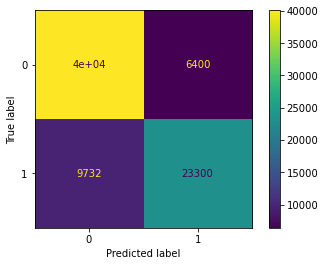

In [26]:
plot_confusion_matrix(ctb_dummy, X_test_dummy, y_test_dummy)
plt.show()

## 2. CatBoost (без преобразования категориальных признаков)

In [58]:
cat_feat

['market',
 'group',
 'archetype',
 'hardware',
 'channel',
 'dealer',
 'type_t',
 'device',
 'date_reg_cat_feat',
 'phone']

In [59]:
df_catf.columns

Index(['client_id', 'date_reg', 'market', 'group', 'archetype', 'hardware',
       'channel', 'dealer', 'phone', 'type_t', 'device', 'churn',
       'quantity_days_traffic', 'all_call_in_num', 'all_call_out_num',
       'all_call_in_dur', 'all_call_out_dur', 'all_out_sms', 'all_gprs',
       'last_day_traffic', 'mean_call_in_dur', 'mean_call_out_dur',
       'all_calls_num', 'all_calls_dur', 'quantity_recharge', 'recharges_sum',
       'last_day_recharge', 'mean_recharges_sum', 'mean_balance',
       'start_balance', 'final_balance', 'difference_balance'],
      dtype='object')

In [61]:
cat_feat_index_ = list()

cat_feat_ = cat_feat.copy()
cat_feat_.remove('date_reg_cat_feat')

for i in cat_feat_:
    cat_feat_index_.append(X_train_catf.columns.get_loc(i))

In [62]:
cat_feat_index_

[0, 1, 2, 3, 4, 5, 7, 8, 6]

In [63]:
X_train_catf.shape

(160529, 29)

In [64]:
%%time
ctb_catf = CatBoostClassifier()
ctb_catf.fit(X_train_catf, y_train_catf, cat_features=cat_feat_index_)

Learning rate set to 0.090096
0:	learn: 0.6521200	total: 347ms	remaining: 5m 46s
1:	learn: 0.6186545	total: 758ms	remaining: 6m 18s
2:	learn: 0.5901251	total: 1.07s	remaining: 5m 55s
3:	learn: 0.5679269	total: 1.4s	remaining: 5m 48s
4:	learn: 0.5493403	total: 1.71s	remaining: 5m 40s
5:	learn: 0.5343561	total: 1.98s	remaining: 5m 27s
6:	learn: 0.5215445	total: 2.26s	remaining: 5m 21s
7:	learn: 0.5115568	total: 2.59s	remaining: 5m 21s
8:	learn: 0.5025605	total: 2.93s	remaining: 5m 22s
9:	learn: 0.4954270	total: 3.25s	remaining: 5m 21s
10:	learn: 0.4896336	total: 3.52s	remaining: 5m 16s
11:	learn: 0.4849740	total: 3.87s	remaining: 5m 18s
12:	learn: 0.4805615	total: 4.28s	remaining: 5m 24s
13:	learn: 0.4771765	total: 4.73s	remaining: 5m 33s
14:	learn: 0.4741965	total: 5.07s	remaining: 5m 33s
15:	learn: 0.4717255	total: 5.44s	remaining: 5m 34s
16:	learn: 0.4697318	total: 5.82s	remaining: 5m 36s
17:	learn: 0.4680000	total: 6.19s	remaining: 5m 37s
18:	learn: 0.4664563	total: 6.56s	remaining: 

158:	learn: 0.4379963	total: 55s	remaining: 4m 51s
159:	learn: 0.4378879	total: 55.4s	remaining: 4m 50s
160:	learn: 0.4378033	total: 55.7s	remaining: 4m 50s
161:	learn: 0.4377136	total: 56s	remaining: 4m 49s
162:	learn: 0.4376589	total: 56.4s	remaining: 4m 49s
163:	learn: 0.4375998	total: 56.7s	remaining: 4m 48s
164:	learn: 0.4375371	total: 56.9s	remaining: 4m 48s
165:	learn: 0.4374492	total: 57.2s	remaining: 4m 47s
166:	learn: 0.4373807	total: 57.6s	remaining: 4m 47s
167:	learn: 0.4373259	total: 57.9s	remaining: 4m 46s
168:	learn: 0.4372820	total: 58.2s	remaining: 4m 46s
169:	learn: 0.4372225	total: 58.5s	remaining: 4m 45s
170:	learn: 0.4371298	total: 58.9s	remaining: 4m 45s
171:	learn: 0.4370886	total: 59.2s	remaining: 4m 44s
172:	learn: 0.4370094	total: 59.6s	remaining: 4m 44s
173:	learn: 0.4369823	total: 59.9s	remaining: 4m 44s
174:	learn: 0.4369376	total: 1m	remaining: 4m 43s
175:	learn: 0.4368630	total: 1m	remaining: 4m 43s
176:	learn: 0.4367835	total: 1m	remaining: 4m 42s
177:	l

312:	learn: 0.4295491	total: 1m 44s	remaining: 3m 48s
313:	learn: 0.4295250	total: 1m 44s	remaining: 3m 48s
314:	learn: 0.4294810	total: 1m 44s	remaining: 3m 48s
315:	learn: 0.4294038	total: 1m 45s	remaining: 3m 47s
316:	learn: 0.4293993	total: 1m 45s	remaining: 3m 47s
317:	learn: 0.4293425	total: 1m 45s	remaining: 3m 47s
318:	learn: 0.4293296	total: 1m 46s	remaining: 3m 46s
319:	learn: 0.4293139	total: 1m 46s	remaining: 3m 46s
320:	learn: 0.4292755	total: 1m 46s	remaining: 3m 46s
321:	learn: 0.4292221	total: 1m 47s	remaining: 3m 45s
322:	learn: 0.4291607	total: 1m 47s	remaining: 3m 45s
323:	learn: 0.4291089	total: 1m 47s	remaining: 3m 45s
324:	learn: 0.4290530	total: 1m 48s	remaining: 3m 44s
325:	learn: 0.4290077	total: 1m 48s	remaining: 3m 44s
326:	learn: 0.4289521	total: 1m 48s	remaining: 3m 43s
327:	learn: 0.4289015	total: 1m 49s	remaining: 3m 43s
328:	learn: 0.4288623	total: 1m 49s	remaining: 3m 43s
329:	learn: 0.4288149	total: 1m 49s	remaining: 3m 42s
330:	learn: 0.4287999	total:

466:	learn: 0.4236841	total: 2m 33s	remaining: 2m 54s
467:	learn: 0.4236439	total: 2m 33s	remaining: 2m 54s
468:	learn: 0.4236370	total: 2m 33s	remaining: 2m 53s
469:	learn: 0.4235932	total: 2m 33s	remaining: 2m 53s
470:	learn: 0.4235598	total: 2m 34s	remaining: 2m 53s
471:	learn: 0.4235263	total: 2m 34s	remaining: 2m 52s
472:	learn: 0.4234770	total: 2m 34s	remaining: 2m 52s
473:	learn: 0.4234510	total: 2m 35s	remaining: 2m 52s
474:	learn: 0.4234149	total: 2m 35s	remaining: 2m 51s
475:	learn: 0.4233588	total: 2m 35s	remaining: 2m 51s
476:	learn: 0.4233300	total: 2m 36s	remaining: 2m 51s
477:	learn: 0.4233036	total: 2m 36s	remaining: 2m 50s
478:	learn: 0.4232870	total: 2m 36s	remaining: 2m 50s
479:	learn: 0.4232709	total: 2m 37s	remaining: 2m 50s
480:	learn: 0.4232381	total: 2m 37s	remaining: 2m 49s
481:	learn: 0.4232080	total: 2m 37s	remaining: 2m 49s
482:	learn: 0.4231916	total: 2m 38s	remaining: 2m 49s
483:	learn: 0.4231372	total: 2m 38s	remaining: 2m 48s
484:	learn: 0.4230898	total:

619:	learn: 0.4190154	total: 3m 21s	remaining: 2m 3s
620:	learn: 0.4189956	total: 3m 22s	remaining: 2m 3s
621:	learn: 0.4189746	total: 3m 22s	remaining: 2m 3s
622:	learn: 0.4189277	total: 3m 22s	remaining: 2m 2s
623:	learn: 0.4189076	total: 3m 23s	remaining: 2m 2s
624:	learn: 0.4188790	total: 3m 23s	remaining: 2m 2s
625:	learn: 0.4188207	total: 3m 23s	remaining: 2m 1s
626:	learn: 0.4187972	total: 3m 23s	remaining: 2m 1s
627:	learn: 0.4187566	total: 3m 24s	remaining: 2m 1s
628:	learn: 0.4187228	total: 3m 24s	remaining: 2m
629:	learn: 0.4187118	total: 3m 24s	remaining: 2m
630:	learn: 0.4186923	total: 3m 25s	remaining: 2m
631:	learn: 0.4186382	total: 3m 25s	remaining: 1m 59s
632:	learn: 0.4185984	total: 3m 25s	remaining: 1m 59s
633:	learn: 0.4185514	total: 3m 26s	remaining: 1m 59s
634:	learn: 0.4185196	total: 3m 26s	remaining: 1m 58s
635:	learn: 0.4184989	total: 3m 26s	remaining: 1m 58s
636:	learn: 0.4184678	total: 3m 27s	remaining: 1m 58s
637:	learn: 0.4184414	total: 3m 27s	remaining: 1m

772:	learn: 0.4146310	total: 4m 11s	remaining: 1m 13s
773:	learn: 0.4146051	total: 4m 11s	remaining: 1m 13s
774:	learn: 0.4145775	total: 4m 12s	remaining: 1m 13s
775:	learn: 0.4145662	total: 4m 12s	remaining: 1m 12s
776:	learn: 0.4145448	total: 4m 12s	remaining: 1m 12s
777:	learn: 0.4145142	total: 4m 13s	remaining: 1m 12s
778:	learn: 0.4144702	total: 4m 13s	remaining: 1m 11s
779:	learn: 0.4144482	total: 4m 14s	remaining: 1m 11s
780:	learn: 0.4144268	total: 4m 14s	remaining: 1m 11s
781:	learn: 0.4143995	total: 4m 14s	remaining: 1m 11s
782:	learn: 0.4143691	total: 4m 15s	remaining: 1m 10s
783:	learn: 0.4143355	total: 4m 15s	remaining: 1m 10s
784:	learn: 0.4142971	total: 4m 15s	remaining: 1m 10s
785:	learn: 0.4142859	total: 4m 15s	remaining: 1m 9s
786:	learn: 0.4142631	total: 4m 16s	remaining: 1m 9s
787:	learn: 0.4142388	total: 4m 16s	remaining: 1m 9s
788:	learn: 0.4142077	total: 4m 16s	remaining: 1m 8s
789:	learn: 0.4141817	total: 4m 17s	remaining: 1m 8s
790:	learn: 0.4141552	total: 4m 1

928:	learn: 0.4105955	total: 5m 2s	remaining: 23.1s
929:	learn: 0.4105719	total: 5m 2s	remaining: 22.8s
930:	learn: 0.4105517	total: 5m 2s	remaining: 22.4s
931:	learn: 0.4105084	total: 5m 3s	remaining: 22.1s
932:	learn: 0.4104733	total: 5m 3s	remaining: 21.8s
933:	learn: 0.4104471	total: 5m 3s	remaining: 21.5s
934:	learn: 0.4104093	total: 5m 3s	remaining: 21.1s
935:	learn: 0.4103951	total: 5m 4s	remaining: 20.8s
936:	learn: 0.4103705	total: 5m 4s	remaining: 20.5s
937:	learn: 0.4103381	total: 5m 5s	remaining: 20.2s
938:	learn: 0.4103151	total: 5m 5s	remaining: 19.8s
939:	learn: 0.4102986	total: 5m 5s	remaining: 19.5s
940:	learn: 0.4102664	total: 5m 6s	remaining: 19.2s
941:	learn: 0.4102319	total: 5m 6s	remaining: 18.9s
942:	learn: 0.4102025	total: 5m 6s	remaining: 18.5s
943:	learn: 0.4101812	total: 5m 7s	remaining: 18.2s
944:	learn: 0.4101414	total: 5m 7s	remaining: 17.9s
945:	learn: 0.4101095	total: 5m 7s	remaining: 17.6s
946:	learn: 0.4100776	total: 5m 7s	remaining: 17.2s
947:	learn: 

In [65]:
ctb_catf_valid_pred = ctb_catf.predict_proba(X_test_catf)[:,1]

In [66]:
roc_auc_score(y_test_catf, ctb_catf_valid_pred)

0.8617829985497893

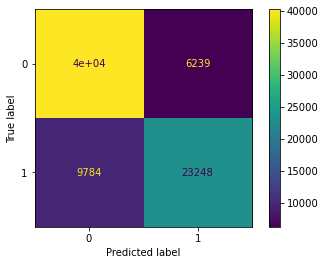

In [67]:
plot_confusion_matrix(ctb_catf, X_test_catf, y_test_catf)
plt.show()

## 3. CatBoost LabelEncoder

In [74]:
cat_feat_index = list()
cat_feat_le = ['market_le', 'group_le', 'archetype_le', 
               'hardware_le', 'channel_le', 'dealer_le', 
               'phone_le', 'type_t_le', 'device_le', 'date_reg_cat_feat_le']
for i in cat_feat_le:
    cat_feat_index.append(X_train_le.columns.get_loc(i))

In [82]:
%%time
ctb_le = CatBoostClassifier()
ctb_le.fit(X_train_le, y_train_le)

Learning rate set to 0.090096
0:	learn: 0.6531719	total: 89.3ms	remaining: 1m 29s
1:	learn: 0.6192556	total: 148ms	remaining: 1m 14s
2:	learn: 0.5921701	total: 239ms	remaining: 1m 19s
3:	learn: 0.5691892	total: 324ms	remaining: 1m 20s
4:	learn: 0.5508333	total: 387ms	remaining: 1m 16s
5:	learn: 0.5373358	total: 481ms	remaining: 1m 19s
6:	learn: 0.5255655	total: 552ms	remaining: 1m 18s
7:	learn: 0.5153364	total: 616ms	remaining: 1m 16s
8:	learn: 0.5067609	total: 681ms	remaining: 1m 15s
9:	learn: 0.5000310	total: 777ms	remaining: 1m 16s
10:	learn: 0.4943955	total: 846ms	remaining: 1m 16s
11:	learn: 0.4895957	total: 919ms	remaining: 1m 15s
12:	learn: 0.4852140	total: 989ms	remaining: 1m 15s
13:	learn: 0.4818331	total: 1.05s	remaining: 1m 14s
14:	learn: 0.4791564	total: 1.11s	remaining: 1m 13s
15:	learn: 0.4769041	total: 1.19s	remaining: 1m 13s
16:	learn: 0.4743759	total: 1.25s	remaining: 1m 12s
17:	learn: 0.4727314	total: 1.31s	remaining: 1m 11s
18:	learn: 0.4710865	total: 1.39s	remaining

159:	learn: 0.4416058	total: 12.6s	remaining: 1m 6s
160:	learn: 0.4415293	total: 12.7s	remaining: 1m 5s
161:	learn: 0.4414418	total: 12.7s	remaining: 1m 5s
162:	learn: 0.4413500	total: 12.8s	remaining: 1m 5s
163:	learn: 0.4412609	total: 12.9s	remaining: 1m 5s
164:	learn: 0.4411215	total: 12.9s	remaining: 1m 5s
165:	learn: 0.4410347	total: 13s	remaining: 1m 5s
166:	learn: 0.4409315	total: 13.1s	remaining: 1m 5s
167:	learn: 0.4408400	total: 13.1s	remaining: 1m 5s
168:	learn: 0.4407704	total: 13.2s	remaining: 1m 4s
169:	learn: 0.4406888	total: 13.3s	remaining: 1m 4s
170:	learn: 0.4406055	total: 13.3s	remaining: 1m 4s
171:	learn: 0.4405264	total: 13.4s	remaining: 1m 4s
172:	learn: 0.4404637	total: 13.4s	remaining: 1m 4s
173:	learn: 0.4403942	total: 13.5s	remaining: 1m 4s
174:	learn: 0.4403192	total: 13.6s	remaining: 1m 3s
175:	learn: 0.4402264	total: 13.6s	remaining: 1m 3s
176:	learn: 0.4401416	total: 13.8s	remaining: 1m 3s
177:	learn: 0.4400251	total: 13.9s	remaining: 1m 4s
178:	learn: 0.

319:	learn: 0.4300275	total: 24.9s	remaining: 52.9s
320:	learn: 0.4299718	total: 25s	remaining: 53s
321:	learn: 0.4299231	total: 25.1s	remaining: 52.9s
322:	learn: 0.4298619	total: 25.2s	remaining: 52.8s
323:	learn: 0.4297963	total: 25.3s	remaining: 52.7s
324:	learn: 0.4297272	total: 25.3s	remaining: 52.6s
325:	learn: 0.4297012	total: 25.4s	remaining: 52.5s
326:	learn: 0.4296462	total: 25.5s	remaining: 52.4s
327:	learn: 0.4295829	total: 25.5s	remaining: 52.3s
328:	learn: 0.4295106	total: 25.6s	remaining: 52.3s
329:	learn: 0.4294404	total: 25.7s	remaining: 52.2s
330:	learn: 0.4293859	total: 25.8s	remaining: 52.1s
331:	learn: 0.4293396	total: 25.9s	remaining: 52s
332:	learn: 0.4292785	total: 25.9s	remaining: 52s
333:	learn: 0.4291983	total: 26s	remaining: 51.9s
334:	learn: 0.4291398	total: 26.1s	remaining: 51.8s
335:	learn: 0.4290710	total: 26.1s	remaining: 51.6s
336:	learn: 0.4290171	total: 26.2s	remaining: 51.5s
337:	learn: 0.4289582	total: 26.3s	remaining: 51.4s
338:	learn: 0.4289089	

479:	learn: 0.4216143	total: 37s	remaining: 40.1s
480:	learn: 0.4215564	total: 37.1s	remaining: 40s
481:	learn: 0.4214868	total: 37.2s	remaining: 39.9s
482:	learn: 0.4214405	total: 37.2s	remaining: 39.8s
483:	learn: 0.4213923	total: 37.3s	remaining: 39.8s
484:	learn: 0.4213476	total: 37.4s	remaining: 39.7s
485:	learn: 0.4213027	total: 37.4s	remaining: 39.6s
486:	learn: 0.4212686	total: 37.5s	remaining: 39.5s
487:	learn: 0.4212262	total: 37.6s	remaining: 39.4s
488:	learn: 0.4211695	total: 37.6s	remaining: 39.3s
489:	learn: 0.4211168	total: 37.7s	remaining: 39.2s
490:	learn: 0.4210786	total: 37.8s	remaining: 39.2s
491:	learn: 0.4210427	total: 37.8s	remaining: 39.1s
492:	learn: 0.4209890	total: 37.9s	remaining: 39s
493:	learn: 0.4209435	total: 38s	remaining: 38.9s
494:	learn: 0.4208878	total: 38s	remaining: 38.8s
495:	learn: 0.4208522	total: 38.1s	remaining: 38.7s
496:	learn: 0.4208096	total: 38.2s	remaining: 38.6s
497:	learn: 0.4207565	total: 38.2s	remaining: 38.5s
498:	learn: 0.4207192	

641:	learn: 0.4143619	total: 49.5s	remaining: 27.6s
642:	learn: 0.4143340	total: 49.6s	remaining: 27.5s
643:	learn: 0.4142866	total: 49.7s	remaining: 27.5s
644:	learn: 0.4142380	total: 49.7s	remaining: 27.4s
645:	learn: 0.4141812	total: 49.8s	remaining: 27.3s
646:	learn: 0.4141448	total: 49.9s	remaining: 27.2s
647:	learn: 0.4141086	total: 50s	remaining: 27.1s
648:	learn: 0.4140593	total: 50.1s	remaining: 27.1s
649:	learn: 0.4140241	total: 50.2s	remaining: 27s
650:	learn: 0.4139884	total: 50.2s	remaining: 26.9s
651:	learn: 0.4139879	total: 50.3s	remaining: 26.8s
652:	learn: 0.4139429	total: 50.3s	remaining: 26.7s
653:	learn: 0.4139031	total: 50.4s	remaining: 26.7s
654:	learn: 0.4138574	total: 50.5s	remaining: 26.6s
655:	learn: 0.4138008	total: 50.6s	remaining: 26.5s
656:	learn: 0.4137665	total: 50.6s	remaining: 26.4s
657:	learn: 0.4137129	total: 50.7s	remaining: 26.4s
658:	learn: 0.4136727	total: 50.8s	remaining: 26.3s
659:	learn: 0.4136387	total: 50.9s	remaining: 26.2s
660:	learn: 0.41

800:	learn: 0.4079572	total: 1m 7s	remaining: 16.8s
801:	learn: 0.4079121	total: 1m 7s	remaining: 16.7s
802:	learn: 0.4078619	total: 1m 7s	remaining: 16.7s
803:	learn: 0.4078259	total: 1m 7s	remaining: 16.6s
804:	learn: 0.4077838	total: 1m 8s	remaining: 16.5s
805:	learn: 0.4077462	total: 1m 8s	remaining: 16.4s
806:	learn: 0.4077094	total: 1m 8s	remaining: 16.3s
807:	learn: 0.4076836	total: 1m 8s	remaining: 16.3s
808:	learn: 0.4076424	total: 1m 8s	remaining: 16.2s
809:	learn: 0.4076072	total: 1m 8s	remaining: 16.1s
810:	learn: 0.4075628	total: 1m 8s	remaining: 16s
811:	learn: 0.4075147	total: 1m 8s	remaining: 15.9s
812:	learn: 0.4074812	total: 1m 8s	remaining: 15.9s
813:	learn: 0.4074518	total: 1m 9s	remaining: 15.8s
814:	learn: 0.4074028	total: 1m 9s	remaining: 15.7s
815:	learn: 0.4073674	total: 1m 9s	remaining: 15.6s
816:	learn: 0.4073363	total: 1m 9s	remaining: 15.6s
817:	learn: 0.4072966	total: 1m 9s	remaining: 15.5s
818:	learn: 0.4072594	total: 1m 9s	remaining: 15.4s
819:	learn: 0.

956:	learn: 0.4022078	total: 1m 24s	remaining: 3.8s
957:	learn: 0.4021717	total: 1m 24s	remaining: 3.72s
958:	learn: 0.4021314	total: 1m 24s	remaining: 3.63s
959:	learn: 0.4020749	total: 1m 25s	remaining: 3.54s
960:	learn: 0.4020413	total: 1m 25s	remaining: 3.46s
961:	learn: 0.4019947	total: 1m 25s	remaining: 3.37s
962:	learn: 0.4019352	total: 1m 25s	remaining: 3.28s
963:	learn: 0.4018959	total: 1m 25s	remaining: 3.19s
964:	learn: 0.4018663	total: 1m 25s	remaining: 3.1s
965:	learn: 0.4018275	total: 1m 25s	remaining: 3.01s
966:	learn: 0.4018030	total: 1m 25s	remaining: 2.92s
967:	learn: 0.4017539	total: 1m 25s	remaining: 2.83s
968:	learn: 0.4017204	total: 1m 25s	remaining: 2.75s
969:	learn: 0.4016886	total: 1m 25s	remaining: 2.66s
970:	learn: 0.4016569	total: 1m 26s	remaining: 2.57s
971:	learn: 0.4016233	total: 1m 26s	remaining: 2.48s
972:	learn: 0.4015733	total: 1m 26s	remaining: 2.39s
973:	learn: 0.4015388	total: 1m 26s	remaining: 2.3s
974:	learn: 0.4014922	total: 1m 26s	remaining: 2.

In [83]:
ctb_le_valid_pred = ctb_le.predict_proba(X_test_le)[:,1]

In [84]:
roc_auc_score(y_test_le, ctb_le_valid_pred)

0.8586344598539517

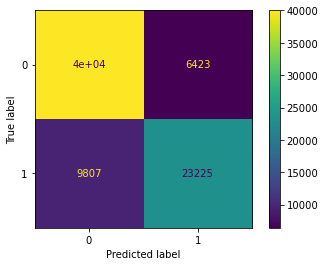

In [85]:
plot_confusion_matrix(ctb_le, X_test_le, y_test_le)
plt.show()